<a href="https://colab.research.google.com/github/TAUforPython/BioMedAI/blob/main/MultiModal%20LLM%20MedCLIP%20SAM%20Brain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MedCLIP-SAM
Уou can use MedCLIP-SAM (Segment-Anything-Model) to generate a pseudo-mask of any image you like.

# How to run?


1.   Setup the environment with all dependencies and libraries
2.   Select your settings for CAM
3.   Put your image (url link or file path from colab) in 'image' blank.
example of brain MRI image:
>https://github.com/TAUforPython/BioMedAI/blob/main/test_datasets/hippocampus.png
4.   Type something at 'prompt'.
5.   Hit play button to generate a saliency
6.   Run the CRF Cell block
7.   Run the SAM Cell block to get the final segmentation output


Special thanks to [HealthX-Lab](https://github.com/HealthX-Lab/MedCLIP-SAM) [open_clip](https://github.com/mlfoundations/open_clip), [gScoreCAM](https://github.com/anguyen8/gScoreCAM), [pydensecrf](https://github.com/lucasb-eyer/pydensecrf), and [segment-anything](https://github.com/facebookresearch/segment-anything) for making their valuable code publicly available.







https://pmc.ncbi.nlm.nih.gov/articles/PMC4598126/pdf/pone.0140381.pdf

https://arxiv.org/abs/2403.20253

In [ ]:
#@title Enviroment setup

# get repo and install env
!git clone https://github.com/HealthX-Lab/MedCLIP-SAM
%cd MedCLIP-SAM/saliency_maps
!pip install  -r colab_requirement.txt
!pip install  validators

import torch
import torchvision
%cd ..
%cd segment-anything
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth


Cloning into 'MedCLIP-SAM'...
remote: Enumerating objects: 320, done.
remote: Counting objects: 100% (320/320), done.
remote: Compressing objects: 100% (262/262), done.
remote: Total 320 (delta 76), reused 273 (delta 47), pack-reused 0 (from 0)
Receiving objects: 100% (320/320), 30.22 MiB | 37.60 MiB/s, done.
Resolving deltas: 100% (76/76), done.
/MedCLIP-SAM/saliency_maps
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-ww6rjpe2
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-ww6rjpe2
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/lucasb-eyer/pydensecrf.git to /tmp/pip-req-build-se42vjug
  Running command git clone --filter=blob:none --quiet https://github.com/lucasb-eyer/pydensecrf.git /tmp/pip-req-build-se42vjug
  Resolved https://github.com/lucasb-eyer/pydensecrf.git to commit 2723c7fa4

In [ ]:
%cd ..
%cd saliency_maps
import os
import open_clip
from model_loader.clip_loader import load_clip
from tools.cam import CAMWrapper
import torch.nn as nn
class BiomedCLIP(nn.Module):
    def __init__(
        self,
        model
    ):
        super().__init__()
        self.model = model

    def forward(self, images,texts):
        # Getting Image and Text Features

        image_embeddings, text_embeddings, logit_scale = self.model(images, texts)

        # Calculating the Loss
        image_logits = (logit_scale * image_embeddings @ text_embeddings.t())
        text_logits = (logit_scale * text_embeddings @ image_embeddings.t())

        return image_logits,text_logits

#@title CAM Settings
clip_version = "ViT-B/16" #@param ["RN50x16", "RN50x4", "RN50", "RN101", "ViT-B/32", "ViT-B/16", "hila"]
cam_version  = 'gScoreCAM' #@param ['GradCAM', 'ScoreCAM', 'GracCAM++', 'AblationCAM', 'XGradCAM', 'EigenCAM', 'EigengradCAM', 'LayerCAM', 'HilaCAM', 'GroupCAM', 'SSCAM1', 'SSCAM2', 'RawCAM', 'GradientCAM', 'gScoreCAM']
#@title ## Markdown

#@markdown Top-k channels used in gScoreCAM (default=100):
topk_channels = 300 #@param {type:"slider", min:1, max:3072, step:1}
cam_version  = cam_version.lower()
is_transformer = 'vit' in clip_version.lower()
model_domain = "biomedclip"

_, _, _, cam_trans, clip = load_clip(clip_version)
biomedclip_model, preprocess = open_clip.create_model_from_pretrained('hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')
tokenizer = open_clip.get_tokenizer('hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')
clip_model = BiomedCLIP(biomedclip_model)
target_layer = clip_model.model.visual.trunk.blocks[11].norm2
cam_wrapper = CAMWrapper(clip_model,
                         preprocess=preprocess,
                         target_layers=[target_layer],
                         tokenizer=clip.tokenize,
                         drop=True,
                         cam_version=cam_version,
                         topk=topk_channels,
                         channels=None,
                         is_transformer=is_transformer,
                         cam_trans=cam_trans,
                         model_domain=model_domain
                         )

def get_visualization(clip_model, cam_wrapper, img, prompt):
  # encode image and prompt
  raw_size    = img.size
  input_img   = preprocess(img).unsqueeze(0).cuda()
  text_token  = tokenizer(prompt).cuda()
  # get cam for prompt and overlay on input image
  cam = cam_wrapper.getCAM(input_img, text_token, raw_size, 0,model_domain=model_domain)

  float_img = img_as_float(img)
  if len(float_img.shape) == 2:
      float_img = color.gray2rgb(float_img)
  cam_img   = show_cam_on_image(float_img, cam, use_rgb=True)
  saliency_map = cam_img.copy()
  cam_img   = Image.fromarray(cam_img)
  cat_img = Image.new('RGB', (raw_size[0]*2, raw_size[1]))
  cat_img.paste(img, (0,0))
  cat_img.paste(cam_img, (raw_size[0],0))
  return cat_img,saliency_map

/MedCLIP-SAM
/MedCLIP-SAM/saliency_maps
ViT-B/16


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_no


> be attention: PNG file MUST have NO alpha chanels



100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


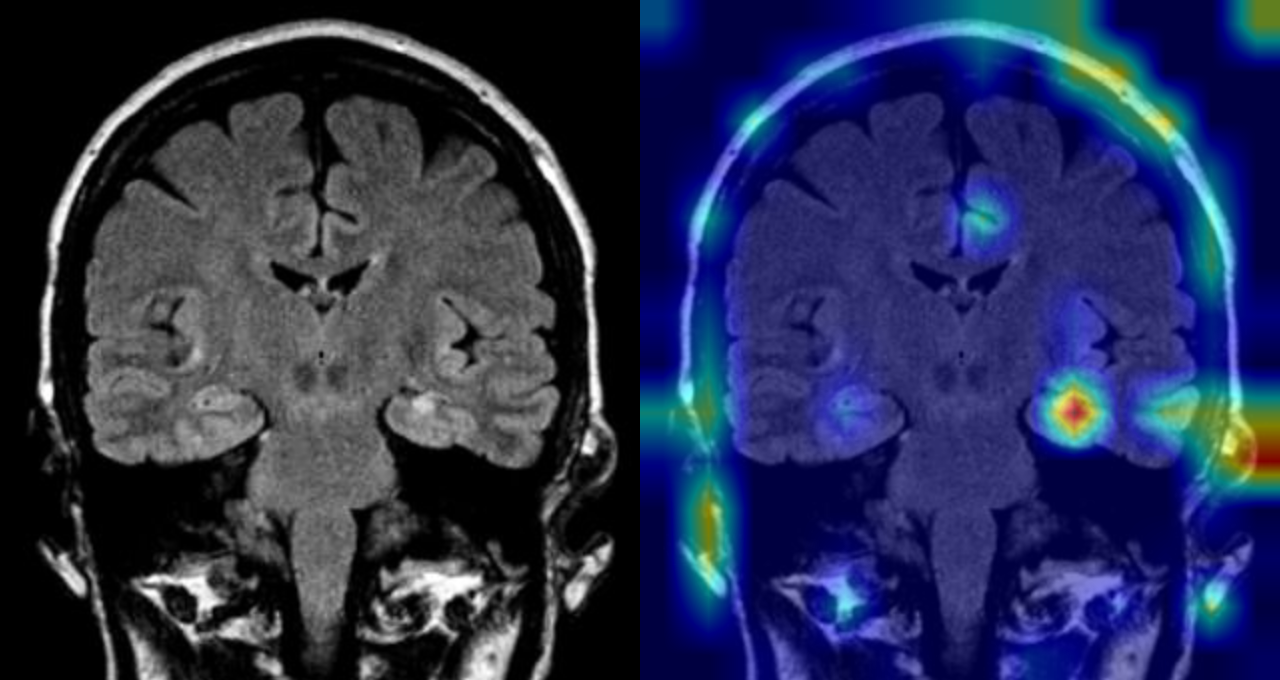

In [ ]:
#@title Step 1: Saliency Maps
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import requests
import urllib.request
from PIL import Image
from skimage.util import img_as_float
from skimage import color
from pytorch_grad_cam.utils.image import show_cam_on_image
from IPython.display import display
import gc
import torch
import validators
gc.collect()
with torch.no_grad():
    torch.cuda.empty_cache()# get image
image = "/content/MedCLIP-SAM/assets/hippocampus.png" #@param {type: "string"}
if validators.url(image) == True:
  try:
    urllib.request.urlretrieve(image, "./temp.jgp")
    image = "./temp.jgp"
    img = Image.open(image)
  except Exception as e:
    print(e)
    raise Exception("image must be a vaild URL.")
else:
  try:
    img = Image.open(image)
  except Exception as e:
    print(e)
    raise Exception("image is not valid.")
# get prompt
prompt = "brain tumor" #@param {type: "string"}

visualization,saliency_map = get_visualization(clip_model, cam_wrapper, img, prompt)

display(visualization)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
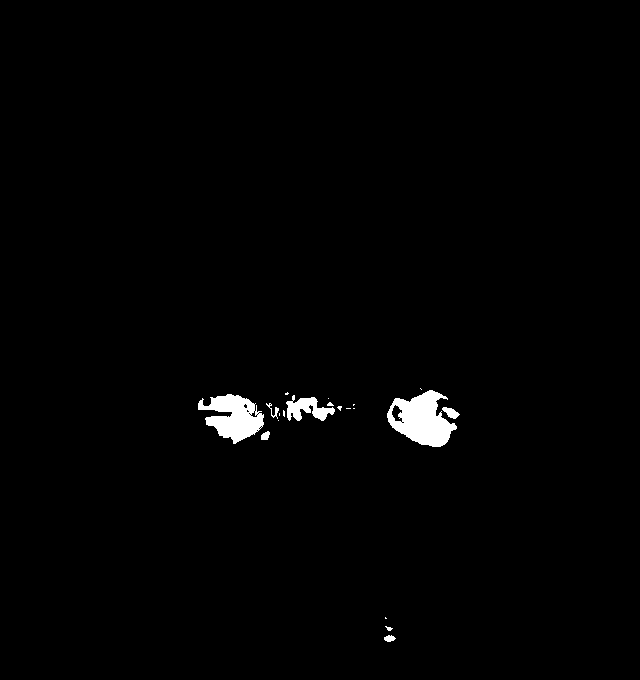

In [ ]:
#@title Step 2: CRF Post-processing
import numpy as np
import cv2
import pydensecrf.densecrf as dcrf
from skimage.segmentation import relabel_sequential
import os
import argparse

M = 2 #@param {type: "number"}
tau = 1.2 #@param {type: "slider", min:1, max:2, step:0.05}
gaussian_sxy = 25 #@param {type: "number"}
gaussian_rgb = 5 #@param {type: "number"}
bilateral_sxy = 25 #@param {type: "number"}
bilateral_srgb = 5 #@param {type: "number"}

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def postprocess_crf():

    img = cv2.imread(image, 1)
    annos = np.squeeze(saliency_map[:,:,0])
    labels = relabel_sequential(annos)[0].flatten()
    output = image.replace('.png', '_crf.png')

    # Setup the CRF model
    d = dcrf.DenseCRF2D(img.shape[1], img.shape[0], M)

    anno_norm = annos / 255.
    n_energy = -np.log((1.0 - anno_norm + 1e-8)) / (tau * sigmoid(1 - anno_norm))
    p_energy = -np.log(anno_norm + 1e-8) / (tau * sigmoid(anno_norm))

    U = np.zeros((M, img.shape[0] * img.shape[1]), dtype='float32')
    U[0, :] = n_energy.flatten()
    U[1, :] = p_energy.flatten()

    d.setUnaryEnergy(U)

    d.addPairwiseGaussian(sxy=gaussian_sxy, compat=3)
    d.addPairwiseBilateral(sxy=bilateral_sxy, srgb=bilateral_srgb
                           , rgbim=img, compat=5)

    # Do the inference
    Q = d.inference(1)
    map = np.argmax(Q, axis=0).reshape((img.shape[0], img.shape[1]))

    # Save the output as image
    map *= 255
    cv2.imwrite(output, map.astype('uint8'))

    return map.astype('uint8')

mask = postprocess_crf()
display(mask)

In [ ]:
#@title Step 3: SAM Output
%cd ..
%cd segment-anything
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor
_CONTOUR_INDEX = 1 if cv2.__version__.split('.')[0] == '3' else 0

def scoremap2bbox(scoremap, threshold, multi_contour_eval=False):
    height, width = scoremap.shape
    scoremap_image = np.expand_dims((scoremap * 255).astype(np.uint8), 2)
    _, thr_gray_heatmap = cv2.threshold(
        src=scoremap_image,
        thresh=int(threshold * np.max(scoremap_image)),
        maxval=255,
        type=cv2.THRESH_BINARY)
    contours = cv2.findContours(
        image=thr_gray_heatmap,
        mode=cv2.RETR_TREE,
        method=cv2.CHAIN_APPROX_SIMPLE)[_CONTOUR_INDEX]

    if len(contours) == 0:
        return np.asarray([[0, 0, width, height]]), 1

    if not multi_contour_eval:
        contours = [max(contours, key=cv2.contourArea)]

    estimated_boxes = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        x0, y0, x1, y1 = x, y, x + w, y + h
        x1 = min(x1, width - 1)
        y1 = min(y1, height - 1)
        estimated_boxes.append([x0, y0, x1, y1])

    return estimated_boxes, contours

sam_checkpoint = "sam_vit_h_4b8939.pth" #@param {type:"string"}
model_type = "vit_h" #@param ["vit_h", "vit_b","vit_l"] {type:"string"}
device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)
img = cv2.imread(image)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
boxes, _ = scoremap2bbox(mask, 0, multi_contour_eval=False)
predictor.set_image(img)
boxes = np.array(boxes)
masks, _, _ = predictor.predict(
point_coords=None,
point_labels=None,
box=boxes,
multimask_output=False
)
output = image.replace('.png', '_sam.png')
mask_sam = np.squeeze(masks*255).astype('uint8')
cv2.imwrite(output,mask_sam)
display(mask_sam)

/MedCLIP-SAM
/MedCLIP-SAM/segment-anything


/MedCLIP-SAM/segment-anything/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)